In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd
import datetime as d
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [22]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [23]:
# Save references to each table
Station = Base.classes.station
Measurement= Base.classes.measurement

In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
most_recent = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent, '%Y-%m-%d')

print(most_recent_date)

2017-08-23 00:00:00


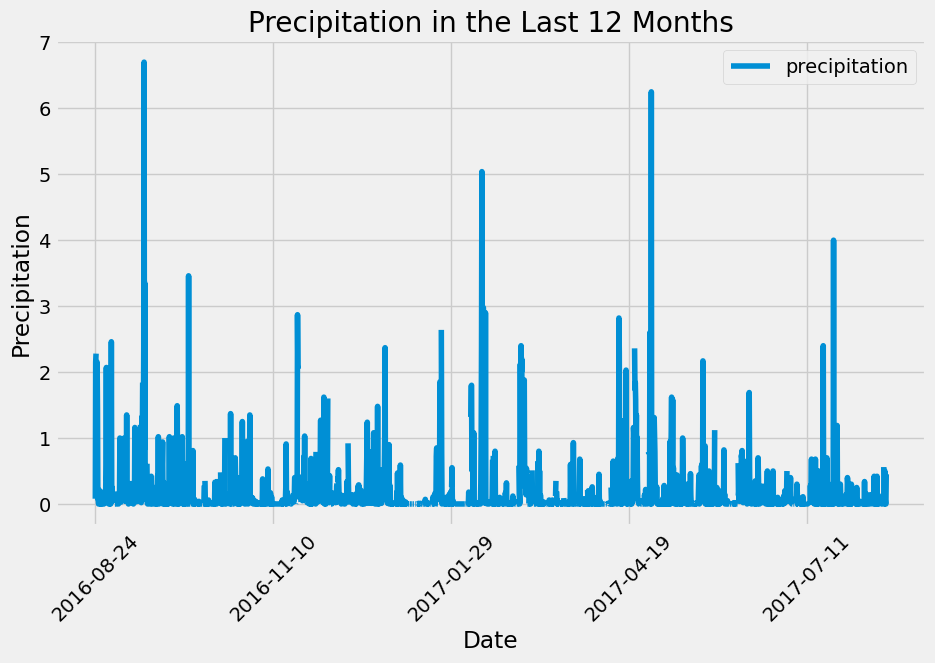

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precip_df = precip_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.set_index('date', inplace=True)
precip_df.plot(figsize=(10, 6), title='Precipitation in the Last 12 Months', rot=45)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats=precip_df['precipitation'].describe()
summary_stats_df = pd.DataFrame(summary_stats)
summary_stats_df

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [27]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station.station).count()
print(station_count)

9


In [28]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
station_precip_counts = session.query(Measurement.station, func.count(Measurement.prcp)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.prcp).desc()).all()

station_precip_counts_df = pd.DataFrame(station_precip_counts, columns=['station', 'count'])

# List the stations and their counts in descending order.
print(station_precip_counts_df)

       station  count
0  USC00519281   2772
1  USC00513117   2696
2  USC00519397   2685
3  USC00519523   2572
4  USC00516128   2484
5  USC00514830   1937
6  USC00511918   1932
7  USC00517948    683
8  USC00518838    342


In [29]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Determine the most active station
most_active_station = station_precip_counts_df.iloc[0]['station']

# Perform a query to calculate the lowest, highest, and average temperatures for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

# Save the query results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

# Print the results
print(f"Most Active Station ID: {most_active_station}")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp:.2f}")

Most Active Station ID: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


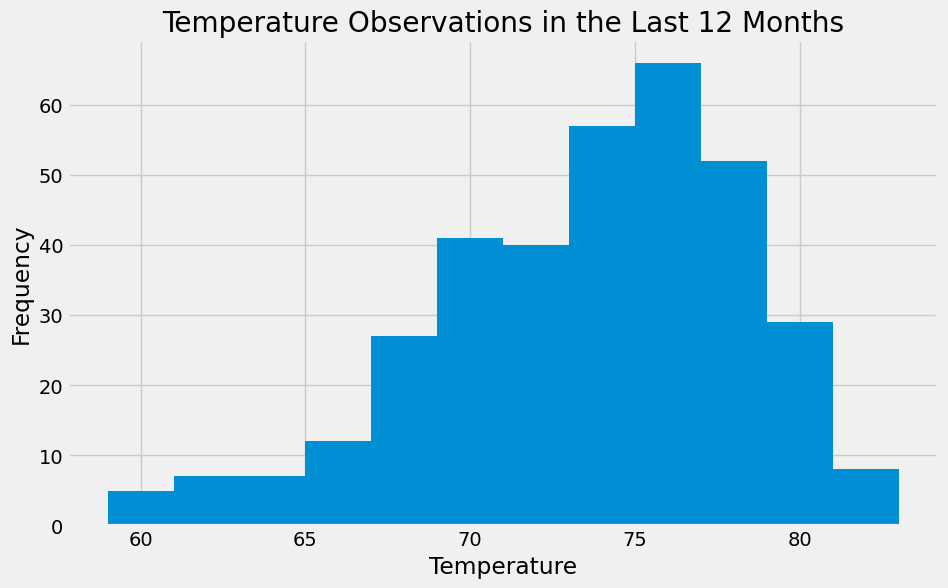

In [30]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

temperature_df = pd.DataFrame(temperature_data, columns=['date', 'temperature'])

# Convert date column from string to datetime
temperature_df['date'] = pd.to_datetime(temperature_df['date'])

# Plot the temperature observations as a histogram
temperature_df['temperature'].plot(kind='hist', bins=12, figsize=(10, 6), title='Temperature Observations in the Last 12 Months')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()


# Close Session

In [16]:
# Close Session
session.close()